This notebook reproduces the functional sensitivity results in the paper

"Evaluating Sensitivity to the Stick Breaking Prior in Bayesian Nonparametrics"
https://arxiv.org/abs/1810.06587


It loads the model fits from './iris_fits/', so make sure to run the notebook `fit_base_model.ipynb` first. 

In [23]:
import autograd
from autograd import numpy as np
from autograd import scipy as sp

from numpy.polynomial.hermite import hermgauss

np.random.seed(453453)

import paragami
import vittles

from bnpgmm_runjingdev import gmm_clustering_lib as gmm_lib
from bnpmodeling_runjingdev import modeling_lib 
from bnpgmm_runjingdev import utils_lib
from bnpmodeling_runjingdev import cluster_quantities_lib as cluster_lib
from bnpmodeling_runjingdev import optimization_lib
from bnpgmm_runjingdev import functional_sensitivity_lib as fun_sens_lib 


import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from sklearn.decomposition import PCA

from copy import deepcopy

import json 

from tqdm import tqdm

# Load data

In [2]:
# load iris data
dataset_name = 'iris'
features, iris_species = utils_lib.load_data()
dim = features.shape[1]
n_obs = len(iris_species)    

Text(0, 0.5, 'PC2')

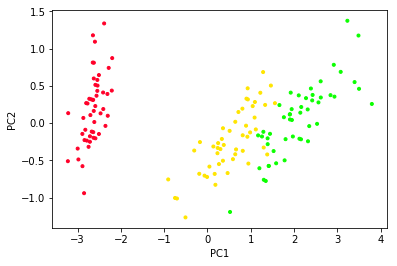

In [3]:
# run PCA
pca_fit = PCA()
pca_fit.fit(features)
pc_features = pca_fit.transform(features)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# Load results from previous fit.

It loads the model fits from './iris_fits/', so make sure to run the notebook `fit_base_model.ipynb` first. 

In [10]:
def assert_optimizer(features, vb_opt_dict, vb_params_paragami, prior_params_dict, gh_loc, gh_weights): 
    # this function checks that vb_opt_dict are at a kl optimum for the given 
    # prior parameters
    
#     get_vb_params_loss = paragami.Functor(original_fun=gmm_lib.get_kl, argnums=1)
#     get_vb_params_loss.cache_args(features, None, prior_params_dict,
#                                     gh_loc, gh_weights)
    get_loss = paragami.FlattenFunctionInput(
        original_fun=lambda par: gmm_lib.get_kl(
            features, par, prior_params_dict,
            gh_loc, gh_weights),
        patterns=vb_params_paragami,
        free=True)
    grad_get_loss = autograd.grad(get_loss)
    linf_grad = np.max(np.abs(grad_get_loss(
        vb_params_paragami.flatten(vb_opt_dict, free = True))))
    
    assert  linf_grad < 1e-5, 'error: {}'.format(linf_grad)


In [11]:
init_alpha = 8.0

# load optimal vb parameters at init_alpha
vb_opt_dict, vb_params_paragami, data =\
    paragami.load_folded('./iris_fits/iris_fits_alpha{}.npz'.format(init_alpha))

# free optimal vb_parameters
vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

# load prior parameters
prior_params_dict, prior_params_paragami = \
    gmm_lib.get_default_prior_params(dim = vb_opt_dict['centroids'].shape[0])
prior_params_dict['alpha'] = data['alpha']

# other parameters
gh_deg = int(data['gh_deg'])
gh_loc, gh_weights = hermgauss(gh_deg)

# optimal e_z
e_z_opt = gmm_lib.get_optimal_z_from_vb_params_dict(features, vb_opt_dict, gh_loc, gh_weights)

# assert we are at an optimum 
assert_optimizer(features, vb_opt_dict, vb_params_paragami, prior_params_dict, gh_loc, gh_weights)

### Plot results

In [12]:
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_params_dict['centroids'], 
                                               np.linalg.inv(vb_params_dict['gamma']))
    
    bnp_clusters = np.argmax(e_z, axis = 1)
    
    cmap = cm.get_cmap(name='gist_rainbow')
    colors1 = [cmap(k * 50) for k in range(30)]

    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])


Text(0, 0.5, 'PC2')

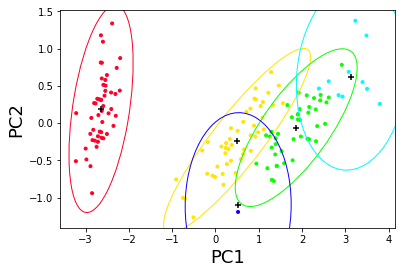

In [13]:
# Newton results
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, vb_opt_dict, e_z_opt, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


# Define a prior perturbation

In [14]:
# this is the phi chosen in figure 2 of the paper

def log_phi(logit_v):
    return(sp.special.expit(logit_v))

def phi(logit_v):
    return np.exp(log_phi(logit_v))


In [15]:
logit_v_grid = np.linspace(-8, 8, 200)

v_grid = np.exp(logit_v_grid) / (1 + np.exp(logit_v_grid))

print('phi max: ', np.max(phi(logit_v_grid)))
log_phi_max = np.max(np.abs(np.log(phi(logit_v_grid))))
print('log phi max: ', log_phi_max)

def rescaled_log_phi(logit_v):
    return 10 * log_phi(logit_v) / log_phi_max


phi max:  2.717370405124736
log phi max:  0.9996646498695336


In [16]:
prior_perturbation = fun_sens_lib.PriorPerturbation(
    vb_params_dict = vb_opt_dict, 
    alpha0 = prior_params_dict['alpha'],
    gh_loc = gh_loc, 
    gh_weights = gh_weights, 
    log_phi = rescaled_log_phi, logit_v_ub=8, logit_v_lb = -8)
print(
    prior_perturbation.log_norm_p0,
    prior_perturbation.log_norm_pc,
    prior_perturbation.log_norm_p0_logit,
    prior_perturbation.log_norm_pc_logit)

-2.079441541679836 1.936236507197625 -2.0821248162554524 1.9385325300641851


Text(0.5, 1.0, 'Priors in logit space')

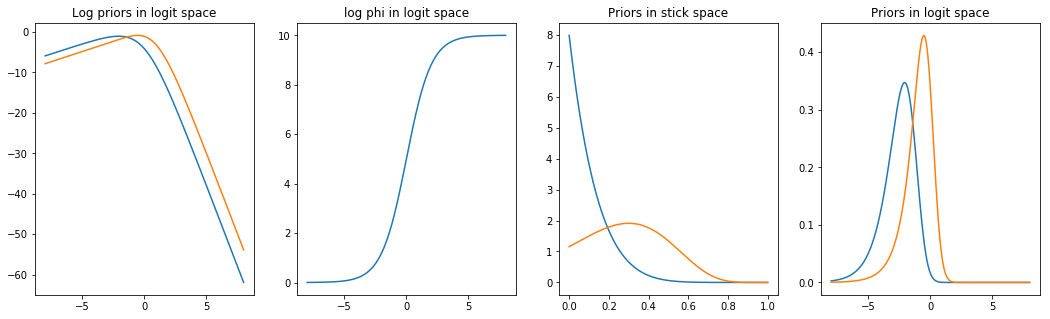

In [17]:
prior_perturbation.set_epsilon(1.0)

plt.figure(1, figsize=(18, 5))

plt.subplot(141)
plt.plot(logit_v_grid, prior_perturbation.get_log_p0_logit(logit_v_grid))
plt.plot(logit_v_grid, prior_perturbation.get_log_pc_logit(logit_v_grid))
plt.title('Log priors in logit space')

plt.subplot(142)
plt.plot(logit_v_grid, prior_perturbation.log_phi(logit_v_grid))
plt.title('log phi in logit space')

plt.subplot(143)
plt.plot(v_grid, np.exp(prior_perturbation.get_log_p0(v_grid)))
plt.plot(v_grid, np.exp(prior_perturbation.get_log_pc(v_grid)))
plt.title('Priors in stick space')

plt.subplot(144)
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)))
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)))
plt.title('Priors in logit space')


# Increase number of Gauss-hermite points.

In [18]:
# First fit with no perturbation but the increased number of gh points.

gh_loc, gh_weights = hermgauss(20)

# get loss as a function of vb parameters
# get_vb_params_loss = paragami.Functor(original_fun=gmm_lib.get_kl, argnums=1)
# get_vb_params_loss.cache_args(features, None, prior_params_dict,
#                                 gh_loc, gh_weights)

# # Get loss as a function vb_free_params
# get_loss = paragami.FlattenedFunction(original_fun=get_vb_params_loss,
#                                         patterns=vb_params_paragami,
#                                         free=True)

get_loss = paragami.FlattenFunctionInput(
    lambda param: gmm_lib.get_kl(features, param, prior_params_dict,
                                gh_loc, gh_weights),
    patterns=vb_params_paragami, free=True)

init_vb_free_params = deepcopy(vb_opt)
vb_opt, _ = optimization_lib.precondition_and_optimize(get_loss, init_vb_free_params,
                    maxiter = 50, gtol=1e-8)

print('Done. ')

Computing Hessian to set preconditioner
preconditioning time: 11.04
running newton steps
Iter 0: f = -337.20754826
Iter 1: f = -337.20754827
Optimization terminated successfully.
         Current function value: -337.207548
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Done. 


In [19]:
vb_opt_dict = vb_params_paragami.fold(vb_opt, free = True)
e_z_opt = gmm_lib.get_optimal_z_from_vb_params_dict(features, vb_opt_dict, gh_loc, gh_weights)

Text(0, 0.5, 'PC2')

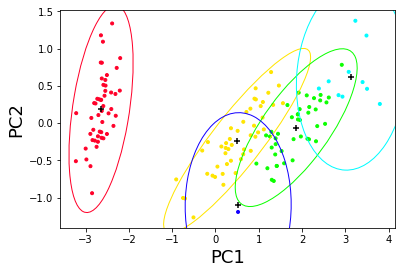

In [20]:
# plot results
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, vb_opt_dict, e_z_opt, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


# Define linear approximation class

In [24]:
# we will use this for the sensitivity class
# get_epsilon_vb_loss = paragami.Functor(
#     original_fun=fun_sens_lib.get_perturbed_kl, argnums=[1, 2])

# get_epsilon_vb_loss.cache_args(features, None, None, rescaled_log_phi, 
#                      prior_params_dict, gh_loc, gh_weights)

get_epsilon_vb_loss = paragami.FlattenFunctionInput(
    lambda param, epsilon: fun_sens_lib.get_perturbed_kl(
        features, param, epsilon, rescaled_log_phi, 
                     prior_params_dict, gh_loc, gh_weights),
    patterns=vb_params_paragami, free=True)

hyper_par_objective_fun = paragami.FlattenFunctionInput(
    lambda param, epsilon: fun_sens_lib.get_e_log_perturbation(
        rescaled_log_phi, param, epsilon, gh_loc, gh_weights),
    patterns=vb_params_paragami, free=True)

In [ ]:
# # the only part of the kl that depends on epsilon
# hyper_par_objective_fun = \
#     paragami.Functor(fun_sens_lib.get_e_log_perturbation, argnums = [1, 2])

# # the kl as a function of both the vb parameters and the hyperparameter
# hyper_par_objective_fun.cache_args(rescaled_log_phi, None, None, 
#                            gh_loc, gh_weights)

In [25]:
# Compute hyper sensitivity object
# epsilon_sens = \
#     paragami.HyperparameterSensitivityLinearApproximation(
#         objective_fun=           get_epsilon_vb_loss,
#         opt_par_pattern=         vb_params_paragami,
#         hyper_par_pattern=       epsilon_param_paragami,
#         opt_par_folded_value=    vb_params_paragami.fold(vb_opt, free = True),
#         hyper_par_folded_value=  epsilon_param_paragami.fold(0.0, free = False),
#         opt_par_is_free=         True,
#         hyper_par_is_free=       False,
#         hyper_par_objective_fun = hyper_par_objective_fun,
#         grad_tol=                1e-5)
epsilon_sens = \
    vittles.ParametricSensitivityTaylorExpansion(
        objective_function =               get_epsilon_vb_loss,
        hyper_par_objective_function =     hyper_par_objective_fun,
        input_val0 = vb_opt,
        hyper_val0 = np.array([0]),
        order = 1)

/home/rgiordan/Documents/git_repos/BNP_sensitivity/RegressionClustering/venv/lib/python3.5/site-packages/vittles/sensitivity_lib.py:857: UserWarning: The ParametricSensitivityTaylorExpansion is experimental.
  'The ParametricSensitivityTaylorExpansion is experimental.')


## Fit with perturbation

In [26]:
epsilon = 1.0 
print('Epsilon: ', epsilon)

vb_pert_pred = \
    epsilon_sens.evaluate_taylor_series(epsilon)

print('Predicted differences: ', np.linalg.norm(vb_pert_pred - vb_opt))

Epsilon:  1.0
Predicted differences:  6.189662015677288


In [27]:
vb_pert_pred_dict = vb_params_paragami.fold(vb_pert_pred, free = True)
e_z_pert_pred = gmm_lib.get_optimal_z_from_vb_params_dict(features, vb_pert_pred_dict, gh_loc, gh_weights)

In [28]:
# get flattened perturbed KL
def get_loss_for_epsilon(epsilon):
    get_perturbed_vb_loss_flattened = paragami.FlattenFunctionInput(
        lambda params: 
            fun_sens_lib.get_perturbed_kl(
                features, params, epsilon, rescaled_log_phi, 
                 prior_params_dict, gh_loc, gh_weights),
        argnums=0,
        patterns=vb_params_paragami,
        free=True)
    return get_perturbed_vb_loss_flattened

get_perturbed_vb_loss_flattened = get_loss_for_epsilon(epsilon)

# get_perturbed_vb_loss = paragami.Functor(
#     original_fun=fun_sens_lib.get_perturbed_kl, argnums=[1])

# get_perturbed_vb_loss.cache_args(features, None, epsilon_param_dict, rescaled_log_phi, 
#                      prior_params_dict, gh_loc, gh_weights)

# get_perturbed_vb_loss_flattened = \
#     paragami.FlattenedFunction(original_fun=get_perturbed_vb_loss,
#                                 patterns=vb_params_paragami,
#                                 free=True)


In [29]:
vb_pert_opt = optimization_lib.optimize_full(get_perturbed_vb_loss_flattened, deepcopy(vb_opt),
                    bfgs_max_iter = 500, netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8)

running bfgs ... 
Iter 0: f = -383.65238730
Iter 1: f = -385.75516985
Iter 2: f = -365.28142402
Iter 3: f = -385.93951728
Iter 4: f = -386.25320345
Iter 5: f = -386.85406950
Iter 6: f = -387.73406387
Iter 7: f = -388.26813170
Iter 8: f = -389.17672633
Iter 9: f = -390.11938738
Iter 10: f = -391.48505956
Iter 11: f = -391.44573233
Iter 12: f = -392.16595690
Iter 13: f = -393.12974436
Iter 14: f = -394.51197051
Iter 15: f = -393.05881868
Iter 16: f = -394.97001726
Iter 17: f = -395.79919315
Iter 18: f = -396.68673781
Iter 19: f = -397.89572846
Iter 20: f = -397.63660756
Iter 21: f = -398.45663580
Iter 22: f = -399.43057865
Iter 23: f = -398.27611600
Iter 24: f = -399.73894426
Iter 25: f = -399.90177357
Iter 26: f = -400.14616553
Iter 27: f = -400.59007934
Iter 28: f = -401.36741688
Iter 29: f = -401.72829449
Iter 30: f = -401.92654570
Iter 31: f = -402.04508422
Iter 32: f = -402.26162826
Iter 33: f = -402.60660274
Iter 34: f = -402.99542754
Iter 35: f = -403.24947682
Iter 36: f = -403.47

In [30]:
vb_pert_opt_dict = vb_params_paragami.fold(vb_pert_opt, free = True)
e_z_pert_opt = gmm_lib.get_optimal_z_from_vb_params_dict(features, vb_pert_opt_dict, gh_loc, gh_weights)

Epsilon: 1.0


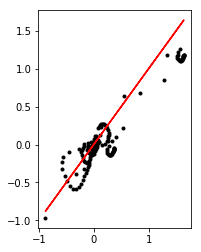

In [31]:
print('Epsilon:', epsilon)

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(vb_pert_opt - vb_opt, vb_pert_pred - vb_opt, 'k.')
plt.plot(vb_pert_opt - vb_opt, vb_pert_opt - vb_opt, 'r')


In [32]:
print('original expected number of clusters: ',
    cluster_lib.get_e_number_clusters_from_logit_sticks(vb_opt_dict['stick_propn_mean'], 
                                                        vb_opt_dict['stick_propn_info'], 
                                                        n_obs = 150, 
                                                        n_samples = 10000))

print('perturbed expected number of clusters: ',
    cluster_lib.get_e_number_clusters_from_logit_sticks(vb_pert_opt_dict['stick_propn_mean'], 
                                                        vb_pert_opt_dict['stick_propn_info'], 
                                                        n_obs = 150, 
                                                        n_samples = 10000))

print('predicted expected number of clusters: ',
    cluster_lib.get_e_number_clusters_from_logit_sticks(vb_pert_pred_dict['stick_propn_mean'], 
                                                        vb_pert_pred_dict['stick_propn_info'], 
                                                        n_obs = 150, 
                                                        n_samples = 10000))


      

original expected number of clusters:  11.02529438826174
perturbed expected number of clusters:  8.41720310339044
predicted expected number of clusters:  8.217579434199974


# Predict for a range of perturbations

In [33]:
# The range of epsilons we shall consider
epsilon_vec = np.linspace(0, 1, 11) ** 2 # Square to get more points close to 0
print(epsilon_vec)

[0.   0.01 0.04 0.09 0.16 0.25 0.36 0.49 0.64 0.81 1.  ]


In [34]:
def refit_with_epsilon(epsilon, init_vb_opt):
    # sets new epsilon, returns new vb optimum
    
    get_perturbed_vb_loss_flattened = get_loss_for_epsilon(epsilon)

#     # set up new objective, with the prior changed
#     get_perturbed_vb_loss = paragami.Functor(
#         original_fun=fun_sens_lib.get_perturbed_kl, argnums=[1])
    
#     get_perturbed_vb_loss.cache_args(features, None, epsilon_param_dict, rescaled_log_phi, 
#                          prior_params_dict, gh_loc, gh_weights)

#     get_perturbed_vb_loss_flattened = \
#         paragami.FlattenedFunction(original_fun=get_perturbed_vb_loss,
#                                     patterns=vb_params_paragami,
#                                     free=True)
    
    # optimize
    vb_opt_pert = optimization_lib.optimize_full(
        get_perturbed_vb_loss_flattened, deepcopy(init_vb_opt),
        bfgs_max_iter = 0, netwon_max_iter = 50,
        max_precondition_iter = 10,
        gtol=1e-8, ftol=1e-8, xtol=1e-8)
    
    return vb_opt_pert

In [35]:
vb_pert_opt_array = []
vb_pert_pred_array = []


for i in range(len(epsilon_vec)): 
    epsilon = epsilon_vec[i]
    print('\n\nEpsilon: ', epsilon)
    
    # get linear predictions
    vb_pert_pred = \
        epsilon_sens.evaluate_taylor_series(epsilon)

    print('Predicted differences: ', np.linalg.norm(vb_pert_pred - vb_opt))
    
    # Then fit with the perturbation.
    vb_pert_opt = refit_with_epsilon(epsilon, vb_opt)
    
    print('Done. ')

    print('Predicted differences: ', np.linalg.norm(vb_pert_pred - vb_opt))
    print('Actual differences: (This is nonzero if phi did anything):',
          np.linalg.norm(vb_pert_opt - vb_opt))
    
    # save results: 
    vb_pert_opt_array.append(vb_pert_opt)
    vb_pert_pred_array.append(vb_pert_pred)
    




Epsilon:  0.0
Predicted differences:  0.0

 running preconditioned newton; iter =  0
Computing Hessian to set preconditioner
preconditioning time: 17.19
running newton steps
Iter 0: f = -337.20754827
Iter 1: f = -337.20754827
         Current function value: -337.207548
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Iter 0: x_diff = 1.205294165255305e-12, f_diff = 2.7284841053187847e-12, grad_l1 = 1.5685369631377905e-08
done. 
Done. 
Predicted differences:  0.0
Actual differences: (This is nonzero if phi did anything): 1.2776111616926088e-13


Epsilon:  0.010000000000000002
Predicted differences:  0.061896620156772726

 running preconditioned newton; iter =  0
Computing Hessian to set preconditioner
preconditioning time: 15.46
running newton steps
Iter 0: f = -337.67199666
Iter 1: f = -337.67338815
Iter 2: f = -337.67338819
Iter 3: f = -337.67338819
         Current function value: -337.673388
         Iteratio

preconditioning time: 14.68
running newton steps
Iter 0: f = -366.93224525
Iter 1: f = -370.97658288
Iter 2: f = -373.90471233
Iter 3: f = -374.19625531
Iter 4: f = -374.25594948
Iter 5: f = -374.27759336
Iter 6: f = -374.28271107
Iter 7: f = -374.28325036
Iter 8: f = -374.28325460
Iter 9: f = -374.28325461
Iter 10: f = -374.28325461
Iter 11: f = -374.28325461
Iter 12: f = -374.28325461
Iter 13: f = -374.28325461
Iter 14: f = -374.28325461
Iter 15: f = -374.28325461
Iter 16: f = -374.28325461
Iter 17: f = -374.28325461
Iter 18: f = -374.28325461
Iter 19: f = -374.28325461
Iter 20: f = -374.28325461
Iter 21: f = -374.28325461
Iter 22: f = -374.28325461
Iter 23: f = -374.28325461
Optimization terminated successfully.
         Current function value: -374.283255
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 13
         Hessian evaluations: 0
Iter 0: x_diff = 37.55523193456464, f_diff = 7.351009358003921, grad_l1 = 7.767245148078777e-10
done. 
Don

/home/rgiordan/Documents/git_repos/BNP_sensitivity/RegressionClustering/venv/lib/python3.5/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)


Iter 1: f = 1426.22447195
Iter 2: f = -191.75890240
Iter 3: f = -382.65461058
Iter 4: f = -384.56714096
Iter 5: f = -384.99987021
Iter 6: f = -385.44358605
Iter 7: f = -385.59296590
Iter 8: f = -385.81767919
Iter 9: f = -386.13848148
Iter 10: f = -385.88050239
Iter 11: f = -386.27032361
Iter 12: f = -386.60535953
Iter 13: f = -386.55054170
Iter 14: f = -386.74639666
Iter 15: f = -387.08285508
Iter 16: f = -387.59022784
Iter 17: f = -387.81569460
Iter 18: f = -388.95899705
Iter 19: f = -389.01307790
Iter 20: f = -389.01307790
Iter 21: f = -389.17540641
Iter 22: f = -389.26945789
Iter 23: f = -389.37565783
Iter 24: f = -389.61825894
Iter 25: f = -389.74317992
Iter 26: f = -389.82544745
Iter 27: f = -390.37948275
Iter 28: f = -390.50124947
Iter 29: f = -391.42245481
Iter 30: f = -391.74449647
Iter 31: f = -393.95717024
Iter 32: f = -394.15480063
Iter 33: f = -394.28268716
Iter 34: f = -397.65601798
Iter 35: f = -398.05030761
Iter 36: f = -398.12943999
Iter 37: f = -398.27223167
Iter 38: f

# Lets look at the expected number of clusters

### Number of in sample clusters

In [37]:
threshold = 0

lr_e_num_clusters_vec = np.zeros(len(epsilon_vec))
refit_e_num_clusters_vec = np.zeros(len(epsilon_vec))

for i in tqdm(range(len(epsilon_vec))): 
    # number of clusters as predicted by linear response
    lr_e_num_clusters, _ = gmm_lib.get_e_num_clusters_from_free_par(features, vb_params_paragami, 
                                    vb_pert_pred_array[i],
                                    gh_loc, gh_weights,
                                    threshold = threshold,
                                    n_samples = 1000)
    
    lr_e_num_clusters_vec[i] = lr_e_num_clusters
    
    # number of clusters after refitting 
    refit_e_num_clusters, _ = gmm_lib.get_e_num_clusters_from_free_par(features, vb_params_paragami, 
                                    vb_pert_opt_array[i],
                                    gh_loc, gh_weights,
                                    threshold = threshold,
                                    n_samples = 1000)
    
    refit_e_num_clusters_vec[i] = refit_e_num_clusters
    


100%|██████████| 11/11 [00:00<00:00, 24.40it/s]


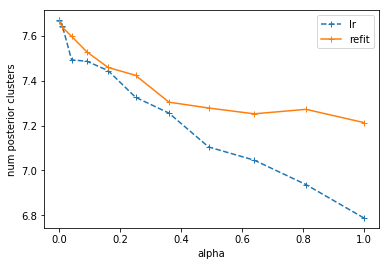

In [38]:
plt.plot(epsilon_vec, lr_e_num_clusters_vec, '+--')
plt.plot(epsilon_vec, refit_e_num_clusters_vec, '+-')

plt.xlabel('alpha')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))


### Number of predicted clusters

In [39]:
threshold = 0

lr_e_num_pred_clusters_vec = np.zeros(len(epsilon_vec))
refit_e_num_pred_clusters_vec = np.zeros(len(epsilon_vec))

for i in tqdm(range(len(epsilon_vec))): 
     # number of clusters as predicted by linear response
    lr_e_num_pred_clusters = gmm_lib.get_e_num_pred_clusters_from_vb_free_params(vb_params_paragami, 
                                    vb_pert_pred_array[i],
                                    n_obs = np.shape(features)[0], 
                                    threshold = threshold,
                                    n_samples = 1000)
    
    lr_e_num_pred_clusters_vec[i] = lr_e_num_pred_clusters
    
    # number of clusters after refitting 
    refit_e_num_pred_clusters = gmm_lib.get_e_num_pred_clusters_from_vb_free_params(vb_params_paragami, 
                                    vb_pert_opt_array[i],
                                    n_obs = np.shape(features)[0], 
                                    threshold = threshold,
                                    n_samples = 1000)
    
    refit_e_num_pred_clusters_vec[i] = refit_e_num_pred_clusters
    


100%|██████████| 11/11 [00:00<00:00, 57.38it/s]


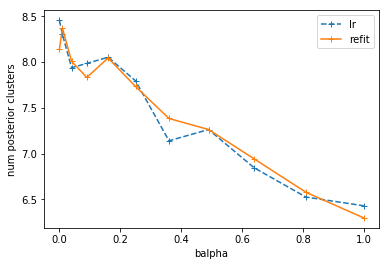

In [40]:
plt.plot(epsilon_vec, lr_e_num_pred_clusters_vec, '+--')
plt.plot(epsilon_vec, refit_e_num_pred_clusters_vec, '+-')

plt.xlabel('balpha')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))